In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
import torch.nn as nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import torch.distributions as D
from tqdm import tqdm

import image_dataset
from hmc_vae import HMCVAE
import utils
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Training Data

In [4]:
train_dataset_in, _ = image_dataset.get('FashionMNIST', 'data')
hidden_channels = 32
in_channels = train_dataset_in.tensors[0].shape[1]
train_dataloader_in = DataLoader(train_dataset_in, batch_size=100, shuffle=False)

### Testing Data

In [5]:
noise_dataset = torchvision.datasets.FakeData(size=5000, image_size=(in_channels, 32, 32), transform=torchvision.transforms.ToTensor())
noise_dataloader = DataLoader(noise_dataset, batch_size=100, shuffle=False)
_, FashionMNIST_dataset = image_dataset.get('FashionMNIST', 'data', 5000)
FashionMNIST_dataloader = DataLoader(FashionMNIST_dataset, batch_size=100, shuffle=False)
_, MNIST_dataset = image_dataset.get('MNIST', 'data', 5000)
MNIST_dataloader = DataLoader(MNIST_dataset, batch_size=100, shuffle=False)

### Model

In [10]:
model_path = "logs/FashionMNIST_17h_21m_17_Jul_2022_seed42/"

model_variational = HMCVAE(in_channels, latent_dim=100, hidden_channels=hidden_channels, T=10, L=5).to(device)
checkpoint = torch.load(model_path + "variational", map_location=device)
model_variational.load_state_dict(checkpoint['model_state_dict'])

model_hmc = HMCVAE(in_channels, latent_dim=100, hidden_channels=hidden_channels, T=10, L=5).to(device)
checkpoint = torch.load(model_path + "hmc_epoch10", map_location=device)
model_hmc.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### Utilities

In [11]:
from sklearn import metrics
def plot(x1, x2=None):
    if type(x1) is torch.Tensor:
        x1 = x1.cpu().numpy()
        x2 = x2.cpu().numpy()
    plt.hist(x1, bins=50, alpha=0.4)
    if x2 is not None:
        plt.hist(x2, bins=50, alpha=0.4)
    plt.show()

def aucroc(score_in, score_out):
    if type(score_in) is torch.Tensor:
        score_in = score_in.cpu().numpy()
        score_out = score_out.cpu().numpy()
    ytrue = np.array([0]*len(score_in) + [1]*len(score_out))
    yscore = np.concatenate([score_in, score_out])
    fpr, tpr, thresholds = metrics.roc_curve(ytrue, yscore)
    plt.plot(fpr, tpr)
    return metrics.auc(fpr, tpr)

### Forward pass

In [14]:
def forward(model, dataloader, hmc):
    model.eval()
    likelihood = []
    entropy = []
    with torch.no_grad():
        for x, _ in tqdm(dataloader):
            x = x.to(device)
            pz = model.encode(x)
            z = pz.rsample()
            if hmc:
                z, accept_prob = model.run_hmc(x, z)
            x_logits = model.decode(z)
            d = D.Categorical(logits=x_logits)
            logp_x = d.log_prob(x.int()).sum(dim=(-1, -2, -3))
            likelihood.append(logp_x)
            entropy.append(d.entropy().sum(dim=(-1, -2, -3)))
    return torch.cat(likelihood), torch.cat(entropy)

In [15]:
lik_var_in, ent_var_in = forward(model_variational, FashionMNIST_dataloader, False)
lik1, ent1 = forward(model_variational, MNIST_dataloader, False)

100%|██████████| 50/50 [00:29<00:00,  1.69it/s]


100%|██████████| 50/50 [00:30<00:00,  1.63it/s]


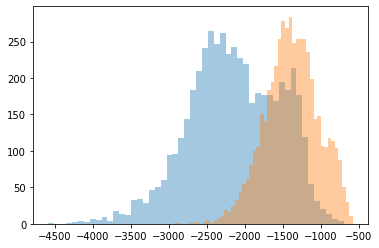

In [22]:
plot(lik, lik1)

0.14464672

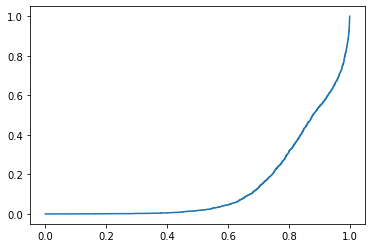

In [24]:
aucroc(-lik, -lik1)